# Setup experiments: code, configs

In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import torch
import matplotlib.pyplot as plt
from consema.conformal import Conformalizer

# from universeg import universeg  # installed via Makefile

# model = universeg(pretrained=True)

GPUNAME = "cuda:0"
device_str = GPUNAME if torch.cuda.is_available() else "cpu"
# device = torch.device(device_str)

# _ = model.to(device)

RANDOM_SEED = 1

In [2]:
random_seed = RANDOM_SEED
device_str = device_str
score_funcs = ["fixed_disk", "variable_disk", "thresholding"]
covratios = [0.99, 0.999, 0.99999]
alphas = [0.05, 0.10]
se_shapes = ["cross", "square"]


chosen_nc_score = score_funcs[0]
# chosen_nc_score = score_funcs[1]
# chosen_nc_score = score_funcs[2]


wbc_params = dict()
oasis_params = {}
polyps_params = {}

In [3]:
from benchmarkerie.datasets import setup_polyps

(
    calib_images,
    calib_gt_arrays,
    calib_pred_arrays,
    test_images,
    test_gt_arrays,
    test_pred_arrays,
) = setup_polyps(RANDOM_SEED, 0.5)

 --- Loading precomp preds from: /home/luca.mossina/projects/vision/consema/benchmarks/polyps_precomputed/data/polyps
n_samples = 250


In [4]:
data_calib = tuple(
    (img, gt, softpred)
    for img, gt, softpred in zip(calib_images, calib_gt_arrays, calib_pred_arrays)
)
print(f" --- n calibration points: {len(data_calib)}")

 --- n calibration points: 250


In [5]:
from benchmarkerie.models import PranetPolypsPrecomputedInferencer

inferencer = PranetPolypsPrecomputedInferencer()
se_params = dict(strict_radius=True)  # [3 X 3] cross
cpred = Conformalizer(
    inferencer=inferencer,
    nonconformity_function_name=chosen_nc_score,
    structuring_element_params=se_params,
)

covratio = 0.99
confo_resu = cpred.compute_nonconformity_scores(data_calib, covratio)

250it [00:02, 106.71it/s]


 --- Required coverage ratio = 0.99
 --- Probability of succes on test = 0.9
 --- Chosen nonconformity score: fixed_disk


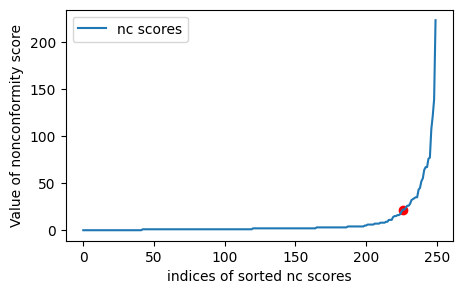

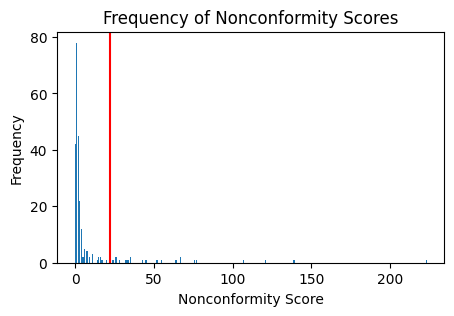

In [6]:
alpha = 0.1
print(f" --- Required coverage ratio = {covratio}")
print(f" --- Probability of succes on test = {1 - alpha}")
print(f" --- Chosen nonconformity score: {chosen_nc_score}")
cpred.plot_nc_scores(alpha_risk=alpha)
cpred.plot_nc_scores_frequency(alpha=alpha)

In [7]:
data_test = tuple(
    (img, gt, softpred)
    for img, gt, softpred in zip(test_images, test_gt_arrays, test_pred_arrays)
)

print(f" --- Required coverage ratio = {covratio}")
print(f" --- Probability of succes on test = {1 - alpha}")
print()
_test_preds = cpred.test_inferences(data_test)
test_results = cpred.test_conformalization(_test_preds, alpha, covratio)

 --- Required coverage ratio = 0.99
 --- Probability of succes on test = 0.9



conformalizing_quantile = 22


In [8]:
empirical_coverage = np.mean(test_results.conformal_tests)
empirical_covratio = np.mean(test_results.empirical_covratios)
empirical_avg_stretch = np.mean(test_results.stretch_factors)

print(
    f" --- cov : {empirical_coverage:.4f} vs nominal : {1-alpha}, for num elements: {len(test_results.conformal_tests)}"
)
print(
    f" --- average {empirical_covratio = :.4f} -vs- {covratio = :.4f} (not covered by guarantee)"
)
print(f" --- {empirical_avg_stretch = :.4f}")

 --- cov : 0.9240 vs nominal : 0.9, for num elements: 250
 --- average empirical_covratio = 0.9669 -vs- covratio = 0.9900 (not covered by guarantee)
 --- empirical_avg_stretch = 2.1587
